In [2]:
%%capture
%run table.ipynb

# Compose a function to calculate the shock population of one run

In [3]:
df_w.head()

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W1,960,10,1.56e-10,0,1.04,28.8,0.111,inf,inf,1,2.63,4.45,49.9,noise_c10nh960Buinf
W2,1920,10,9.68e-13,0,1.06,57.7,0.112,inf,inf,1,3.01,4.66,49.8,noise_c10nh1920Buinf
W3,3840,10,6e-15,0,1.1,115,0.113,inf,inf,1,3.6,5.22,49.9,noise_c10nh3840Buinf
W4,7680,10,3.72e-17,0,1.18,231,0.116,inf,inf,1,4.5,6.12,16.9,noise_c10nh7680Buinf
W5,960,20,1.56e-10,0,1,28.8,0.055,inf,inf,1,3.12,4.88,49.9,noise_c20nh960Buinf


In [64]:
df = df_w[df_w["$n$"] == 960]
df

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W1,960,10,1.56e-10,0,1.04,28.8,0.111,inf,inf,1,2.63,4.45,49.9,noise_c10nh960Buinf
W5,960,20,1.56e-10,0,1,28.8,0.055,inf,inf,1,3.12,4.88,49.9,noise_c20nh960Buinf
W9,960,40,1.56e-10,0,0.996,28.8,0.0274,inf,inf,1,3.95,6.02,49.8,noise_c40nh960Buinf
W12,960,100,1.56e-10,0,0.999,28.8,0.011,inf,inf,1,5.92,8.72,49.8,noise_c100nh960Buinf
W16,960,400,1.56e-10,0,1.14,28.8,0.00287,inf,inf,1,12.3,15.9,120,noise_c400nh960Buinf
W19,960,700,1.56e-10,0,1.27,28.8,0.0017,inf,inf,1,16.9,19.1,49.8,noise_c700nh960Buinf


In [168]:
short = df.iloc[4]["short name"]
paths_sim[short]

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=400_L=50.x50._960x960_2016-09-27_18-44-52'

In [169]:
%%capture
from fluidsim import load_state_phys_file

sim = load_state_phys_file(paths_sim[short], merge_missing_params=True)

In [170]:
%matplotlib inline
# from scipy.signal import find_peaks, find_peaks_cwt
from peakutils import indexes
from scipy import ndimage as ndi
import matplotlib.pyplot as plt


def detect_shocks(sim, i0=None, i1=None, debug=False, **kwargs):
    div = sim.state.get_var("div")
    if i0 is not None:
        div1d = div[i0, :]
    elif i1 is not None:
        div1d = div[:, i1]
    else:
        raise ValueError

    div1d_orig = div1d
        
    # filter
    height = (div1d.min(), np.median(div1d))
    # peaks, _ = find_peaks(div1d, height=height, **kwargs)
    peaks = indexes(-div1d, thres=0.6, min_dist=3)
    if debug:
        print("Height =",height)
        print(f"Detected {len(peaks)} peaks")
        plt.figure(dpi=150)
        x = sim.oper.x_seq
        plt.plot(x, div1d_orig, 'k', label="original div")
        # plt.plot(div1d, 'g--', label="preprocessed div")    
        plt.plot(x[peaks], div1d[peaks], "x")
        plt.xlabel("$x$")
        plt.ylabel(r"$\nabla.\bf u$")
        plt.legend()
    else:
        return peaks

In [171]:
sim.output.path_run

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=400_L=50.x50._960x960_2016-09-27_18-44-52'

Height = (-38.65210197581797, 1.310936753562711)
Detected 22 peaks


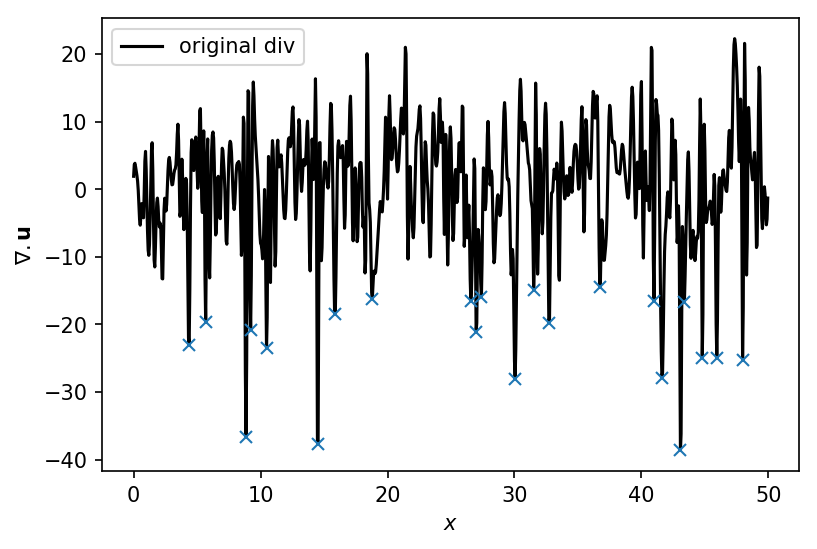

In [172]:
detect_shocks(sim, sim.oper.nx_seq // 2, debug=True)

In [173]:
def avg_shock_seperation_1d(sim, i0=None, i1=None):
    peaks = detect_shocks(sim, i0, i1)
    x_peaks = sim.oper.x_seq[peaks]
    dx_peaks = x_peaks[1:] - x_peaks[:-1]
    return dx_peaks.mean()

avg_shock_seperation_1d(sim, sim.oper.nx // 2)

2.075892857142857

/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


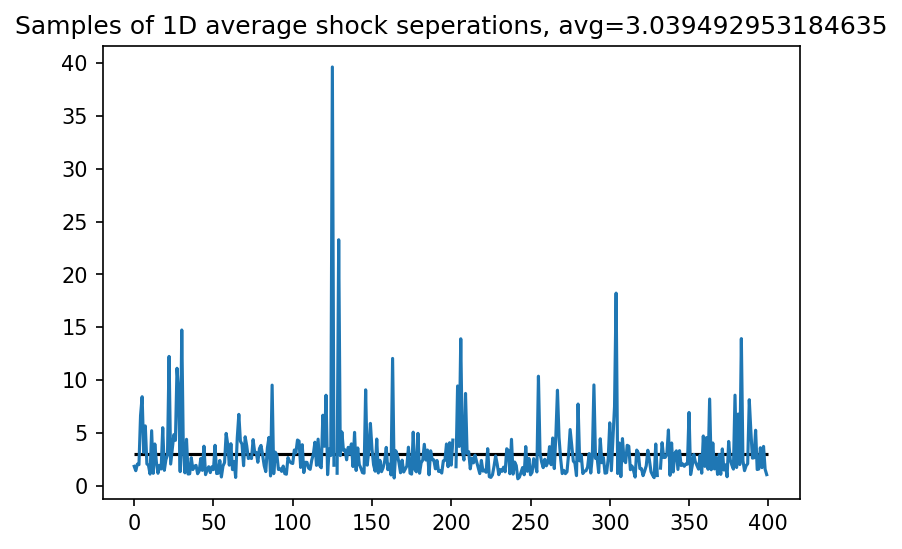

In [174]:
def avg_shock_seperation(sim, num_samples=200, averaged=True):
    ds = []
    for i in np.linspace(0, sim.oper.nx_seq-1, num_samples, dtype=int):
        ds0 = avg_shock_seperation_1d(sim, i0=i)
        ds1 = avg_shock_seperation_1d(sim, i1=i)
        ds.extend([ds0, ds1])
    if averaged:
        return np.nanmean(ds)
    else:
        return ds

ds_avg = avg_shock_seperation(sim, 200, averaged=False)
plt.figure(dpi=150)
ds_avg2 = np.nanmean(ds_avg)
plt.title(f"Samples of 1D average shock seperations, avg={ds_avg2}")
plt.hlines([ds_avg2], 0, len(ds_avg))
plt.plot(ds_avg)

In [175]:
def avg_shock_seperation_from_shortname(short_name):
    path = paths_sim[short_name]
    sim = fls.load_state_phys_file(path, merge_missing_params=True)
    return avg_shock_seperation(sim)

In [181]:
df = df_w[df_w["$n$"] == 1920]
df

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W2,1920,10,9.68e-13,0,1.06,57.7,0.112,inf,inf,1,3.01,4.66,49.8,noise_c10nh1920Buinf
W6,1920,20,9.69e-13,0,1.02,57.7,0.0553,inf,inf,1,3.64,5.61,120,noise_c20nh1920Buinf
W10,1920,40,9.68e-13,0,0.998,57.7,0.0274,inf,inf,1,4.78,7.12,49.8,noise_c40nh1920Buinf
W13,1920,100,9.69e-13,0,1.01,57.7,0.011,inf,inf,1,7.38,10.2,120,noise_c100nh1920Buinf
W17,1920,400,9.69e-13,0,1.15,57.7,0.00288,inf,inf,1,15.5,21.3,120,noise_c400nh1920Buinf
W20,1920,700,9.68e-13,0,1.05,57.7,0.0016,inf,inf,1,19.5,22.2,49.8,noise_c700nh1920Buinf


In [182]:
%%capture
result = df["short name"].apply(avg_shock_seperation_from_shortname)

In [183]:
result

W2    8.85
W6    8.48
W10   6.74
W13   6.52
W17   3.03
W20   2.59
Name: short name, dtype: float64

In [184]:
df

,$n$,$c$,$\nu_8$,$f$,$\epsilon$,$\frac{k_{diss}}{k_f}$,$F_f$,$Ro_f$,$Bu$,$\frac{<\bf \Omega_0 >}{{(P k_f^2)}^{2/3}}$,$E$,$t_{stat}$,$t_{\max}$,short name
W2,1920,10,9.68e-13,0,1.06,57.7,0.112,inf,inf,1,3.01,4.66,49.8,noise_c10nh1920Buinf
W6,1920,20,9.69e-13,0,1.02,57.7,0.0553,inf,inf,1,3.64,5.61,120,noise_c20nh1920Buinf
W10,1920,40,9.68e-13,0,0.998,57.7,0.0274,inf,inf,1,4.78,7.12,49.8,noise_c40nh1920Buinf
W13,1920,100,9.69e-13,0,1.01,57.7,0.011,inf,inf,1,7.38,10.2,120,noise_c100nh1920Buinf
W17,1920,400,9.69e-13,0,1.15,57.7,0.00288,inf,inf,1,15.5,21.3,120,noise_c400nh1920Buinf
W20,1920,700,9.68e-13,0,1.05,57.7,0.0016,inf,inf,1,19.5,22.2,49.8,noise_c700nh1920Buinf


/scratch/avmo/miniconda3/envs/fluidmeta/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


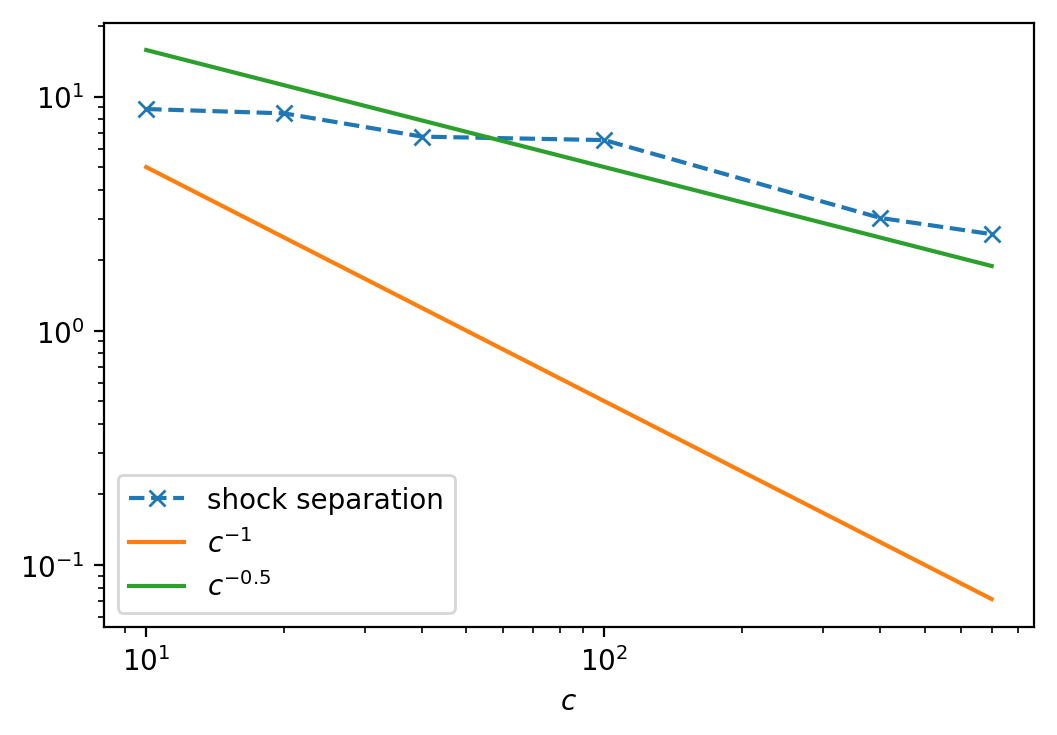

In [185]:
%matplotlib inline
df["shock separation"] = result
fig, ax = plt.subplots(dpi=200)
df.plot(r'$c$', 'shock separation', style="x--", ax=ax, loglog=True)
ax.loglog(df[r'$c$'], 50./df[r'$c$'], label="$c^{-1}$")
ax.loglog(df[r'$c$'], 50./df[r'$c$'] ** 0.5, label="$c^{-0.5}$")
ax.legend()
plt.show()

In [186]:
sim.output.path_run

'/media/avmo/lacie/13KTH/noise/SW1Lwaves_NOISE2_c=400_L=50.x50._960x960_2016-09-27_18-44-52'

In [46]:
short

'noise_c10nh960Buinf'